# 10章 チューニング技法

In [1]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1

In [2]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

In [3]:
# PyTorch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [4]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [5]:
# GPUチェック

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
# 分類先クラスの名称リスト
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 分類先クラス数　今回は10になる
n_output = len(list(set(classes)))

# 結果確認
print(n_output)

10


## 10.4 過学習とその対応

### ドロップアウト関数の動作確認

In [17]:
# ドロップアウトテスト用ダミーデータの作成

torch.manual_seed(123)
inputs = torch.randn(1, 10)
print(inputs)

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969,  0.2093, -0.9724, -0.7550,
          0.3239, -0.1085]])


In [18]:
# dropout関数の定義
dropout = nn.Dropout(0.5)

# 訓練モードでの挙動
dropout.train()
print(dropout.training)
outputs = dropout(inputs)
print(outputs)

# 予測モードでの挙動
dropout.eval()
print(dropout.training)
outputs = dropout(inputs)
print(outputs)

True
tensor([[-0.0000,  0.2407, -0.0000, -0.4808, -0.0000,  0.0000, -1.9447, -0.0000,
          0.6478, -0.2170]])
False
tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969,  0.2093, -0.9724, -0.7550,
          0.3239, -0.1085]])


## 10.5 共通関数のライブラリ化

In [7]:
# 共通関数のダウンロード
!git clone https://github.com/makaishi2/pythonlibs.git

# 共通関数のロード
from pythonlibs.torch_lib1 import *

# 共通関数の存在チェック
print(README)

fatal: destination path 'pythonlibs' already exists and is not an empty directory.
Common Library for PyTorch
Author: M. Akaishi


## データ準備

In [8]:
# transformの定義

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5)
])

In [9]:
# データ取得用関数 DataSet

train_set = datasets.CIFAR10(
    root='./data', train=True, download=True,
    transform=transform)

# 検証データの取得
test_set = datasets.CIFAR10(
    root='./data', train=False, download=True, 
    transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [10]:
# ミニバッチのサイズ指定
batch_size = 100

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader = DataLoader(test_set,  batch_size=batch_size, shuffle=False) 

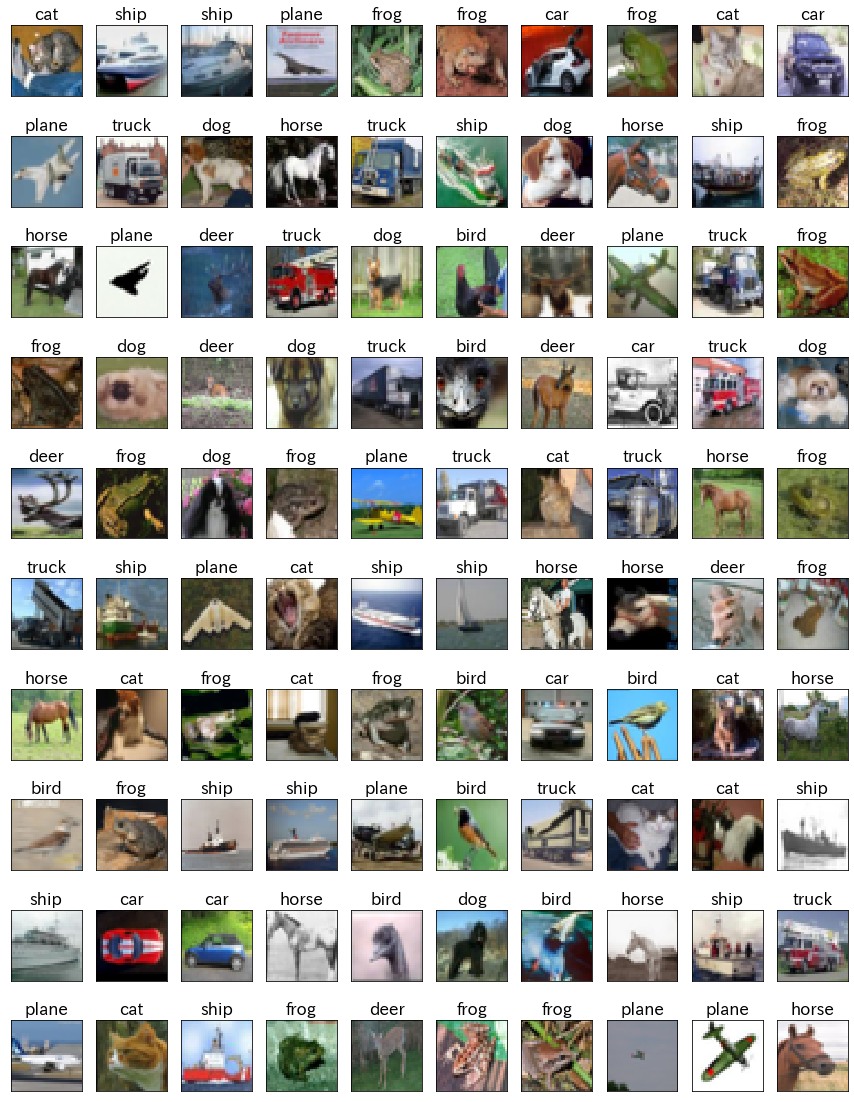

In [11]:
# 最初の100個の表示
for images, labels in test_loader:
    break

plt.figure(figsize=(15, 20))
for i in range(100):
    ax = plt.subplot(10, 10, i + 1)
    image = images[i]
    label = labels[i]
    np_image = image.numpy().copy()
    img = np.transpose(np_image, (1, 2, 0))
    img2 = (img + 1)/2 
    plt.imshow(img2)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 10.6 階層を深くしたモデルの実装

In [ ]:
class CNN_v2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1), padding_mode='replicate')
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1), padding_mode='replicate')
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1), padding_mode='replicate')
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1), padding_mode='replicate')
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1), padding_mode='replicate')
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1), padding_mode='replicate')
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.classifier1 = nn.Linear(4*4*128, 128)
        self.classifier2 = nn.Linear(128, 10)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
            )

        self.classifier = nn.Sequential(
            self.classifier1,
            self.relu,
            self.classifier2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

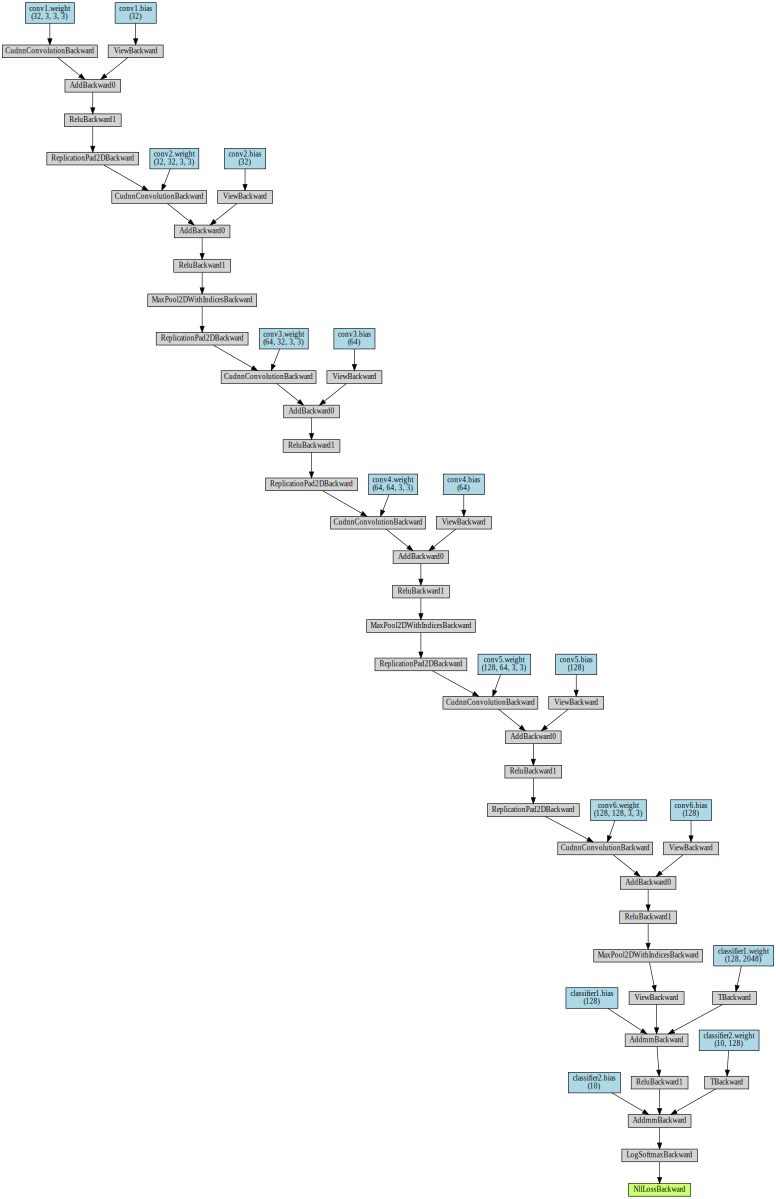

In [ ]:
# 損失関数のグラフ表示
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
make_dot(loss, params=dict(net.named_parameters()))

In [ ]:
lr = 0.01
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)
history = np.zeros((0, 5))

In [ ]:
# 学習

num_epochs = 50
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

Epoch [1/50], loss: 0.02303 acc: 0.10000 val_loss: 0.02303, val_acc: 0.10000
Epoch [2/50], loss: 0.02303 acc: 0.10072 val_loss: 0.02302, val_acc: 0.10000
Epoch [3/50], loss: 0.02302 acc: 0.10056 val_loss: 0.02302, val_acc: 0.10000
Epoch [4/50], loss: 0.02302 acc: 0.10624 val_loss: 0.02302, val_acc: 0.10100
Epoch [5/50], loss: 0.02302 acc: 0.11468 val_loss: 0.02301, val_acc: 0.16700
Epoch [6/50], loss: 0.02301 acc: 0.16920 val_loss: 0.02299, val_acc: 0.20440
Epoch [7/50], loss: 0.02296 acc: 0.19686 val_loss: 0.02288, val_acc: 0.22790
Epoch [8/50], loss: 0.02184 acc: 0.22646 val_loss: 0.02027, val_acc: 0.26750
Epoch [9/50], loss: 0.01974 acc: 0.28722 val_loss: 0.01874, val_acc: 0.33390
Epoch [10/50], loss: 0.01851 acc: 0.33236 val_loss: 0.01759, val_acc: 0.36420
Epoch [11/50], loss: 0.01731 acc: 0.37646 val_loss: 0.01655, val_acc: 0.40950
Epoch [12/50], loss: 0.01637 acc: 0.40902 val_loss: 0.01573, val_acc: 0.42730
Epoch [13/50], loss: 0.01569 acc: 0.43226 val_loss: 0.01548, val_acc: 0.4

初期状態: 損失関数: 0.02303 精度: 0.10000
最終状態: 損失関数: 0.01350 精度: 0.68590


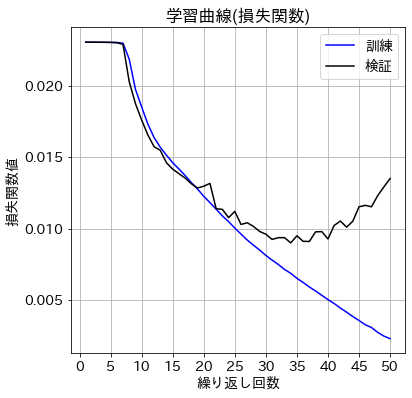

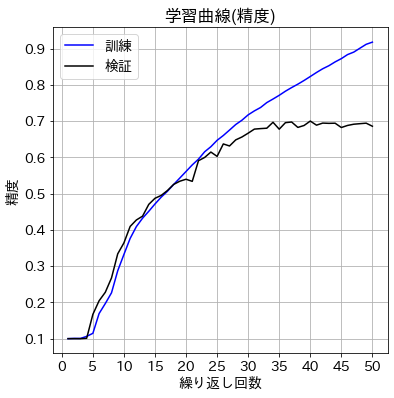

In [ ]:
evaluate_history(history)

## 10.7 最適化関数の選択

### momentumの設定

In [ ]:
# 最適化関数にmomentumを指定

lr = 0.01
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
history2 = np.zeros((0, 5))

In [ ]:
# 学習

num_epochs = 20
history2 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history2)

Epoch [1/20], loss: 0.02280 acc: 0.12162 val_loss: 0.02072, val_acc: 0.20070
Epoch [2/20], loss: 0.01761 acc: 0.35036 val_loss: 0.01582, val_acc: 0.42110
Epoch [3/20], loss: 0.01401 acc: 0.48638 val_loss: 0.01263, val_acc: 0.54750
Epoch [4/20], loss: 0.01136 acc: 0.59248 val_loss: 0.01049, val_acc: 0.62340
Epoch [5/20], loss: 0.00941 acc: 0.66528 val_loss: 0.00886, val_acc: 0.68660
Epoch [6/20], loss: 0.00804 acc: 0.71744 val_loss: 0.00867, val_acc: 0.69950
Epoch [7/20], loss: 0.00681 acc: 0.76096 val_loss: 0.00748, val_acc: 0.74020
Epoch [8/20], loss: 0.00590 acc: 0.79382 val_loss: 0.00743, val_acc: 0.75250
Epoch [9/20], loss: 0.00515 acc: 0.82128 val_loss: 0.00692, val_acc: 0.76630
Epoch [10/20], loss: 0.00431 acc: 0.84950 val_loss: 0.00701, val_acc: 0.77150
Epoch [11/20], loss: 0.00372 acc: 0.86758 val_loss: 0.00745, val_acc: 0.76990
Epoch [12/20], loss: 0.00308 acc: 0.89084 val_loss: 0.00806, val_acc: 0.76080
Epoch [13/20], loss: 0.00252 acc: 0.91100 val_loss: 0.00886, val_acc: 0.7

初期状態: 損失関数: 0.01911 精度: 0.30780
最終状態: 損失関数: 0.01120 精度: 0.76530


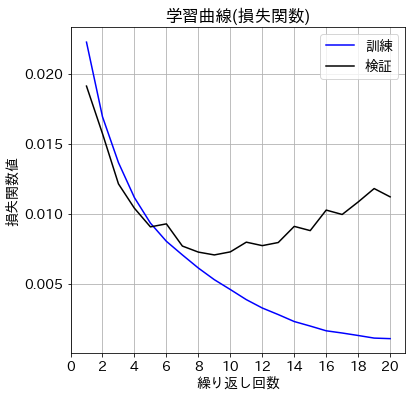

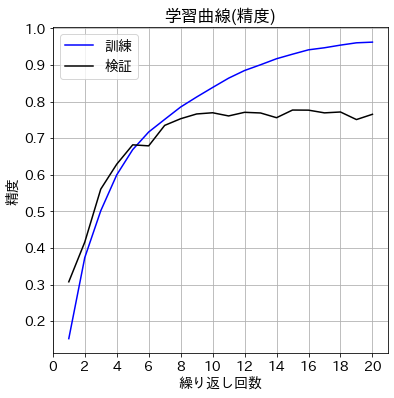

In [ ]:
evaluate_history(history2)

### Adamの利用

In [ ]:
# 最適化関数にAdamを指定

net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history3 = np.zeros((0, 5))

In [ ]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


In [ ]:
# 学習

num_epochs = 20
history3 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history3)

Epoch [1/20], loss: 0.01646 acc: 0.38540 val_loss: 0.01297, val_acc: 0.52120
Epoch [2/20], loss: 0.01188 acc: 0.56910 val_loss: 0.01059, val_acc: 0.62780
Epoch [3/20], loss: 0.00964 acc: 0.65436 val_loss: 0.00916, val_acc: 0.67530
Epoch [4/20], loss: 0.00822 acc: 0.70990 val_loss: 0.00855, val_acc: 0.70320
Epoch [5/20], loss: 0.00718 acc: 0.74700 val_loss: 0.00771, val_acc: 0.73500
Epoch [6/20], loss: 0.00639 acc: 0.77510 val_loss: 0.00707, val_acc: 0.75480
Epoch [7/20], loss: 0.00569 acc: 0.79912 val_loss: 0.00686, val_acc: 0.76860
Epoch [8/20], loss: 0.00517 acc: 0.81800 val_loss: 0.00685, val_acc: 0.77080
Epoch [9/20], loss: 0.00460 acc: 0.83742 val_loss: 0.00714, val_acc: 0.76840
Epoch [10/20], loss: 0.00426 acc: 0.84984 val_loss: 0.00744, val_acc: 0.75490
Epoch [11/20], loss: 0.00364 acc: 0.87094 val_loss: 0.00731, val_acc: 0.77570
Epoch [12/20], loss: 0.00336 acc: 0.87926 val_loss: 0.00762, val_acc: 0.77220
Epoch [13/20], loss: 0.00298 acc: 0.89394 val_loss: 0.00779, val_acc: 0.7

### 結果比較

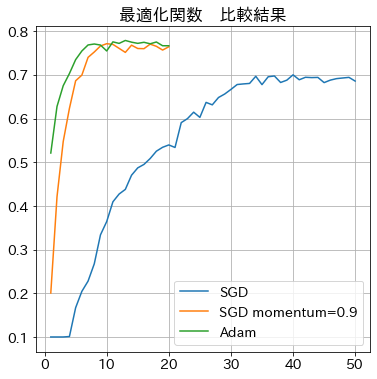

In [ ]:
plt.plot(history[:,0], history[:,4], label='SGD')
plt.plot(history2[:,0], history2[:,4], label='SGD momentum=0.9')
plt.plot(history3[:,0], history3[:,4], label='Adam')
plt.title('最適化関数　比較結果')
plt.legend()
plt.show()

## 10.8 ドロップアウト

In [ ]:
class CNN_v3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1), padding_mode='replicate')
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1), padding_mode='replicate')
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1), padding_mode='replicate')
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1), padding_mode='replicate')
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1), padding_mode='replicate')
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1), padding_mode='replicate')
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.classifier1 = nn.Linear(4*4*128, 128)
        self.classifier2 = nn.Linear(128, 10)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.classifier1,
            self.relu,
            self.dropout3,
            self.classifier2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

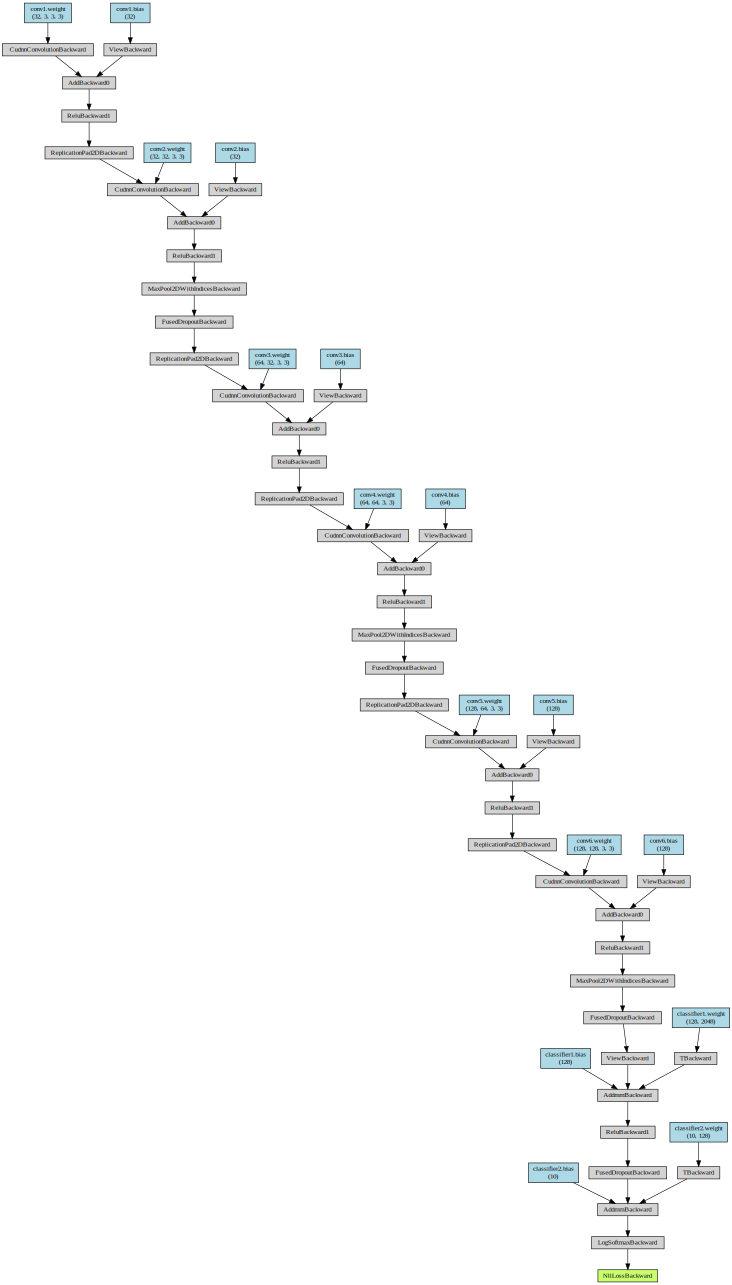

In [ ]:
# 損失関数のグラフ表示
net = CNN_v3(n_output).to(device)
criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
make_dot(loss, params=dict(net.named_parameters()))

In [ ]:
net = CNN_v3(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [ ]:
# 学習

num_epochs = 50
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

Epoch [1/50], loss: 0.01790 acc: 0.33034 val_loss: 0.01418, val_acc: 0.47550
Epoch [2/50], loss: 0.01395 acc: 0.48438 val_loss: 0.01213, val_acc: 0.56240
Epoch [3/50], loss: 0.01207 acc: 0.56200 val_loss: 0.01017, val_acc: 0.63560
Epoch [4/50], loss: 0.01089 acc: 0.61000 val_loss: 0.00927, val_acc: 0.66880
Epoch [5/50], loss: 0.01004 acc: 0.64392 val_loss: 0.00849, val_acc: 0.70130
Epoch [6/50], loss: 0.00932 acc: 0.67078 val_loss: 0.00836, val_acc: 0.70680
Epoch [7/50], loss: 0.00877 acc: 0.69294 val_loss: 0.00769, val_acc: 0.73050
Epoch [8/50], loss: 0.00840 acc: 0.70616 val_loss: 0.00726, val_acc: 0.74040
Epoch [9/50], loss: 0.00805 acc: 0.71776 val_loss: 0.00718, val_acc: 0.75110
Epoch [10/50], loss: 0.00772 acc: 0.73358 val_loss: 0.00704, val_acc: 0.75330
Epoch [11/50], loss: 0.00751 acc: 0.74190 val_loss: 0.00660, val_acc: 0.76920
Epoch [12/50], loss: 0.00724 acc: 0.74788 val_loss: 0.00637, val_acc: 0.77710
Epoch [13/50], loss: 0.00704 acc: 0.75810 val_loss: 0.00647, val_acc: 0.7

初期状態: 損失関数: 0.01418 精度: 0.47550
最終状態: 損失関数: 0.00531 精度: 0.82200


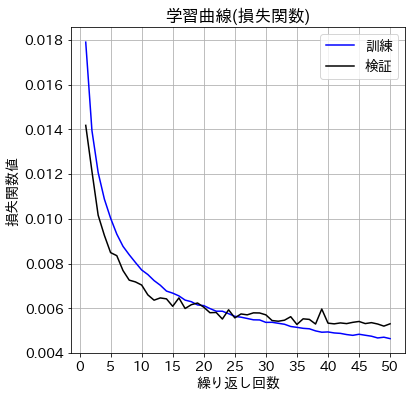

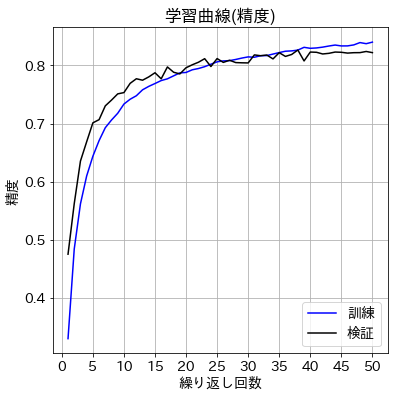

In [ ]:
evaluate_history(history)

## 10.9 Batch Normalization

In [ ]:
class CNN_v4(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1), padding_mode='replicate')
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1), padding_mode='replicate')
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1), padding_mode='replicate')
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1), padding_mode='replicate')
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1), padding_mode='replicate')
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1), padding_mode='replicate')
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.classifier1 = nn.Linear(4*4*128, 128)
        self.classifier2 = nn.Linear(128, 10)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)

        self.features = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.conv2,
            self.bn2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.bn3,
            self.relu,
            self.conv4,
            self.bn4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.bn5,
            self.relu,
            self.conv6,
            self.bn6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.classifier1,
            self.relu,
            self.dropout3,
            self.classifier2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [ ]:
net = CNN_v4(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [ ]:
# 学習

num_epochs = 50
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

Epoch [1/50], loss: 0.01464 acc: 0.46016 val_loss: 0.01120, val_acc: 0.59820
Epoch [2/50], loss: 0.01100 acc: 0.60712 val_loss: 0.00891, val_acc: 0.68410
Epoch [3/50], loss: 0.00964 acc: 0.66100 val_loss: 0.00787, val_acc: 0.72450
Epoch [4/50], loss: 0.00874 acc: 0.69386 val_loss: 0.00718, val_acc: 0.74900
Epoch [5/50], loss: 0.00811 acc: 0.71818 val_loss: 0.00788, val_acc: 0.72480
Epoch [6/50], loss: 0.00758 acc: 0.73998 val_loss: 0.00629, val_acc: 0.77950
Epoch [7/50], loss: 0.00718 acc: 0.75300 val_loss: 0.00579, val_acc: 0.79950
Epoch [8/50], loss: 0.00673 acc: 0.76952 val_loss: 0.00608, val_acc: 0.79320
Epoch [9/50], loss: 0.00644 acc: 0.78122 val_loss: 0.00608, val_acc: 0.79190
Epoch [10/50], loss: 0.00611 acc: 0.79064 val_loss: 0.00533, val_acc: 0.81850
Epoch [11/50], loss: 0.00589 acc: 0.80130 val_loss: 0.00560, val_acc: 0.80740
Epoch [12/50], loss: 0.00564 acc: 0.80822 val_loss: 0.00555, val_acc: 0.81050
Epoch [13/50], loss: 0.00542 acc: 0.81716 val_loss: 0.00535, val_acc: 0.8

初期状態: 損失関数: 0.01120 精度: 0.59820
最終状態: 損失関数: 0.00425 精度: 0.87580


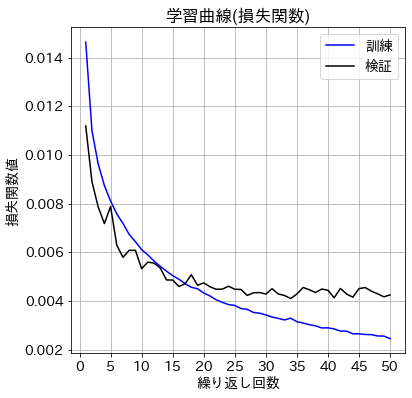

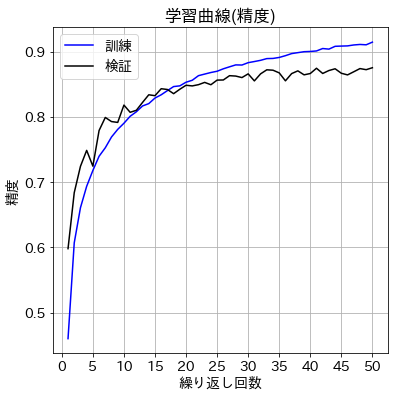

In [ ]:
evaluate_history(history)

## 10.10 Data Augumentation

In [ ]:
# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
transform_train = transforms.Compose([
  transforms.RandomHorizontalFlip(p=0.5), 
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5), 
  transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

In [ ]:
# transfrom_trainを利用したDataSetの定義
train_set2 = datasets.CIFAR10(
    root='./data', train=True, download=True,
    transform=transform_train)

# traisform_trainを利用したLadaLoaderの定義
batch_size = 100
train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


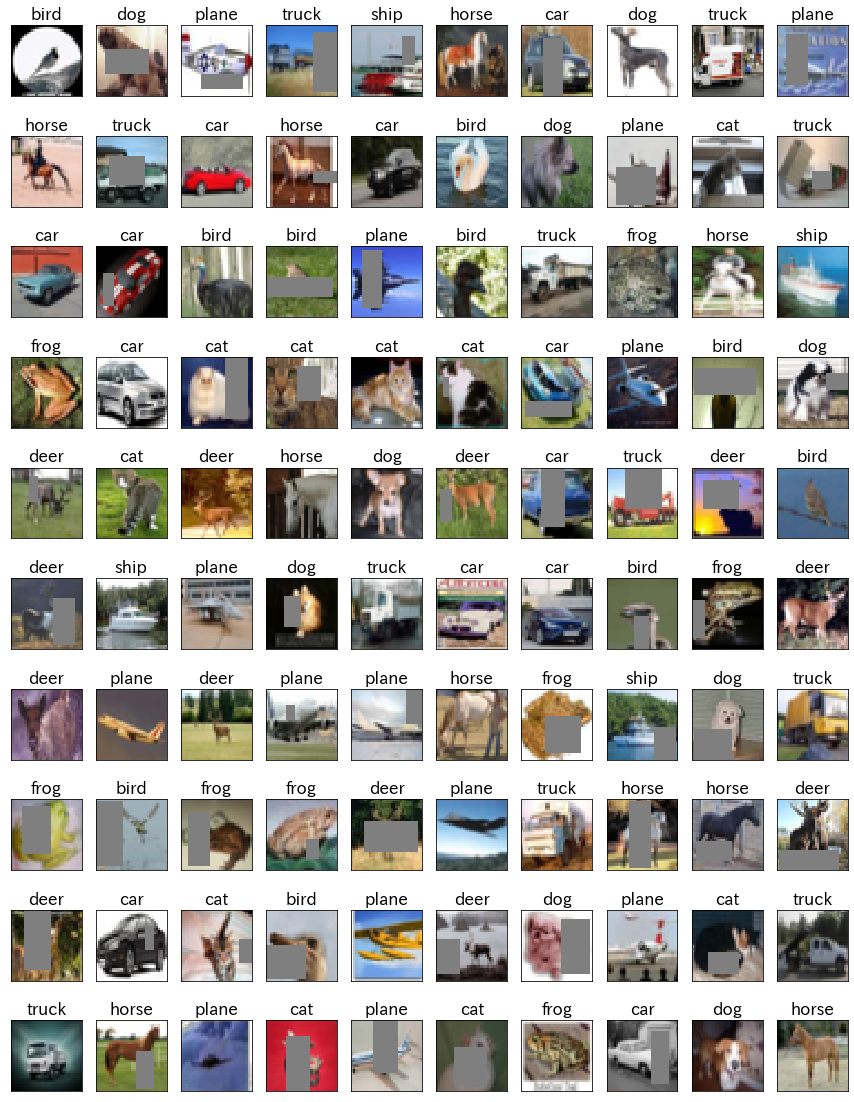

In [ ]:
# 新しい訓練用データの先頭100個を表示してみる

for images, labels in train_loader2:
    break
    
plt.figure(figsize=(15, 20))
for i in range(100):
    ax = plt.subplot(10, 10, i + 1)
    image = images[i]
    label = labels[i]
    np_image = image.numpy().copy()
    img = np.transpose(np_image, (1, 2, 0))
    img2 = (img + 1)/2 
    plt.imshow(img2)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
net = CNN_v4(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [ ]:
# 学習
# 同じモデルでtrain_loader2に変更

num_epochs = 100
history = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader, device, history)

Epoch [1/100], loss: 0.01514 acc: 0.44440 val_loss: 0.01160, val_acc: 0.57930
Epoch [2/100], loss: 0.01198 acc: 0.57124 val_loss: 0.01137, val_acc: 0.60110
Epoch [3/100], loss: 0.01081 acc: 0.61796 val_loss: 0.00912, val_acc: 0.67860
Epoch [4/100], loss: 0.01001 acc: 0.64920 val_loss: 0.00768, val_acc: 0.72680
Epoch [5/100], loss: 0.00949 acc: 0.66860 val_loss: 0.00727, val_acc: 0.74350
Epoch [6/100], loss: 0.00902 acc: 0.68654 val_loss: 0.00682, val_acc: 0.76350
Epoch [7/100], loss: 0.00872 acc: 0.69968 val_loss: 0.00666, val_acc: 0.76860
Epoch [8/100], loss: 0.00836 acc: 0.71256 val_loss: 0.00633, val_acc: 0.78250
Epoch [9/100], loss: 0.00819 acc: 0.71974 val_loss: 0.00604, val_acc: 0.78970
Epoch [10/100], loss: 0.00782 acc: 0.73388 val_loss: 0.00617, val_acc: 0.78900
Epoch [11/100], loss: 0.00770 acc: 0.73768 val_loss: 0.00575, val_acc: 0.80190
Epoch [12/100], loss: 0.00751 acc: 0.74280 val_loss: 0.00557, val_acc: 0.81030
Epoch [13/100], loss: 0.00725 acc: 0.75270 val_loss: 0.00602,

初期状態: 損失関数: 0.01160 精度: 0.57930
最終状態: 損失関数: 0.00347 精度: 0.89370


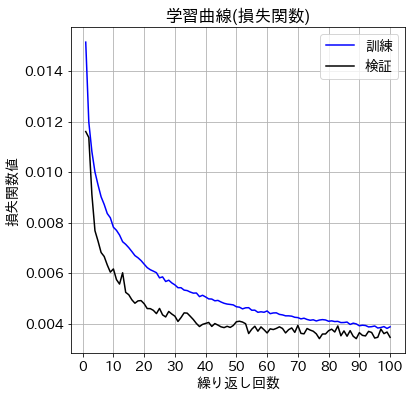

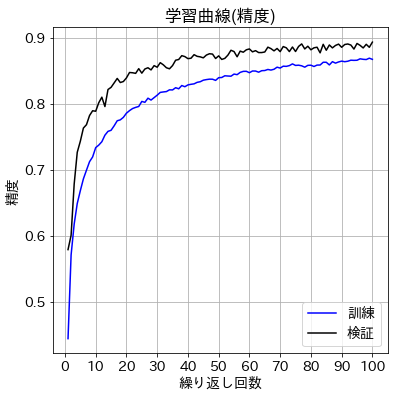

In [ ]:
evaluate_history(history)

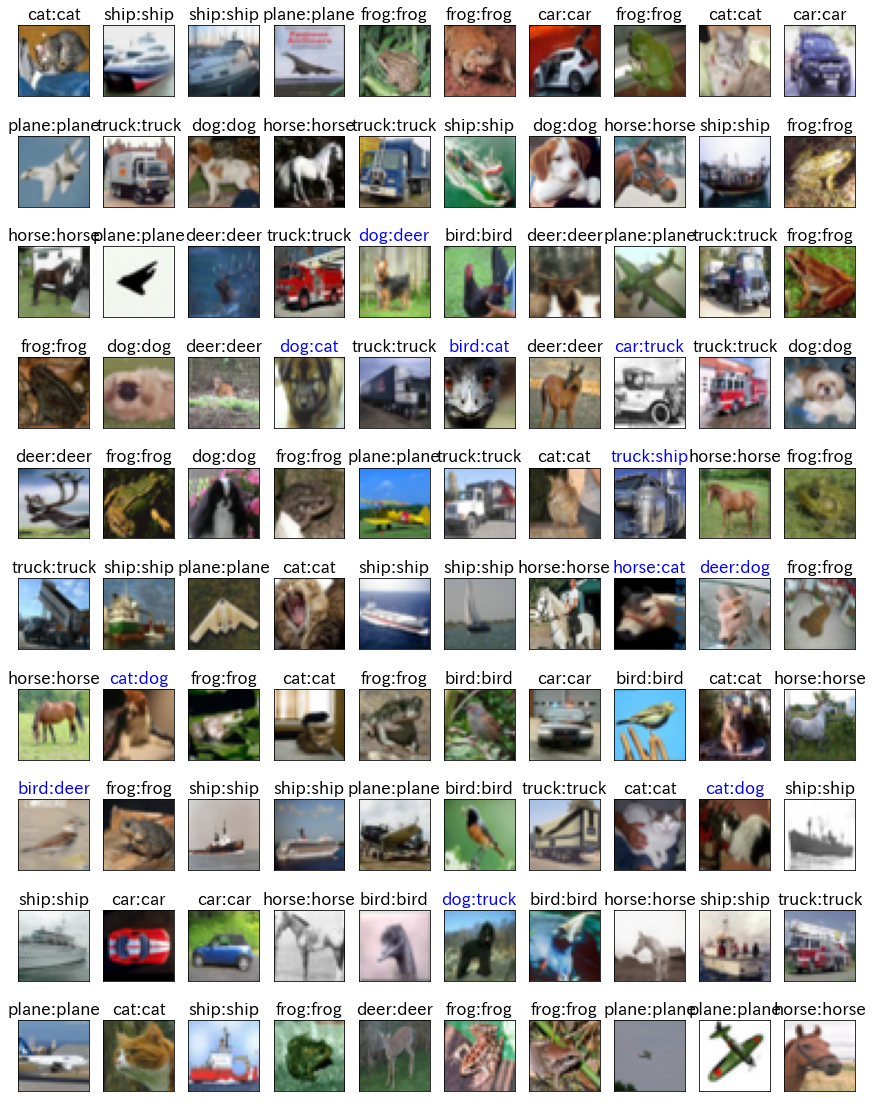

In [ ]:
show_predict_result(net, test_loader, classes, device)

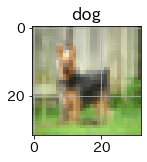

In [ ]:
# 間違えた25番目のデータを抽出
for images, lavels in test_loader:
    break
image = images[24]
label = labels[24]

# イメージを表示して確認
plt.figure(figsize=(2,2))
w = image.numpy().copy()
w2 = np.transpose(w, (1, 2, 0))
w3 = (w2 + 1)/2 
plt.title(classes[label])
plt.imshow(w3)
plt.show()


In [ ]:
# 予測値を取得
image = image.view(1, 3, 32, 32)
image = image.to(device)
output = net(image)

# ラベル別の確率値を表示
probs = torch.softmax(output, dim=1)
probs_np = probs.data.to('cpu').numpy()[0]
names = np.array(classes)
tbl = np.array([names, probs_np]).T
print(tbl)

[['plane' '1.4586017e-07']
 ['car' '5.412343e-09']
 ['bird' '0.0023170759']
 ['cat' '0.117725216']
 ['deer' '0.62583673']
 ['dog' '0.23521532']
 ['frog' '1.1455315e-05']
 ['horse' '0.018893749']
 ['ship' '3.420145e-08']
 ['truck' '2.7773132e-07']]


## コラム　Batch Normalization利用上の注意点

### ダメなクラス定義の例

In [12]:
class CNN_v5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1), padding_mode='replicate')
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1), padding_mode='replicate')
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1), padding_mode='replicate')
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1), padding_mode='replicate')
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1), padding_mode='replicate')
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1), padding_mode='replicate')
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.classifier1 = nn.Linear(4*4*128, 128)
        self.classifier2 = nn.Linear(128, 10)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        self.features = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.conv2,
            self.bn1,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.bn2,
            self.relu,
            self.conv4,
            self.bn2,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.bn3,
            self.relu,
            self.conv6,
            self.bn3,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.classifier1,
            self.relu,
            self.dropout3,
            self.classifier2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [18]:
net = CNN_v5(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
history = np.zeros((0, 5))

In [19]:
# 学習

num_epochs = 50
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

Epoch [1/50], loss: 0.01491 acc: 0.45076 val_loss: 0.02413, val_acc: 0.17370
Epoch [2/50], loss: 0.01128 acc: 0.59754 val_loss: 0.03497, val_acc: 0.14990
Epoch [3/50], loss: 0.00974 acc: 0.65820 val_loss: 0.03782, val_acc: 0.16620
Epoch [4/50], loss: 0.00880 acc: 0.69680 val_loss: 0.03238, val_acc: 0.10210
Epoch [5/50], loss: 0.00815 acc: 0.71908 val_loss: 0.02888, val_acc: 0.10410
Epoch [6/50], loss: 0.00758 acc: 0.74120 val_loss: 0.02962, val_acc: 0.10160
Epoch [7/50], loss: 0.00719 acc: 0.75376 val_loss: 0.03422, val_acc: 0.15710
Epoch [8/50], loss: 0.00682 acc: 0.76710 val_loss: 0.02914, val_acc: 0.14740
Epoch [9/50], loss: 0.00650 acc: 0.77980 val_loss: 0.02757, val_acc: 0.15370
Epoch [10/50], loss: 0.00618 acc: 0.79136 val_loss: 0.02913, val_acc: 0.14780
Epoch [11/50], loss: 0.00596 acc: 0.80050 val_loss: 0.02493, val_acc: 0.14430
Epoch [12/50], loss: 0.00578 acc: 0.80592 val_loss: 0.02564, val_acc: 0.15700
Epoch [13/50], loss: 0.00556 acc: 0.81480 val_loss: 0.02597, val_acc: 0.1

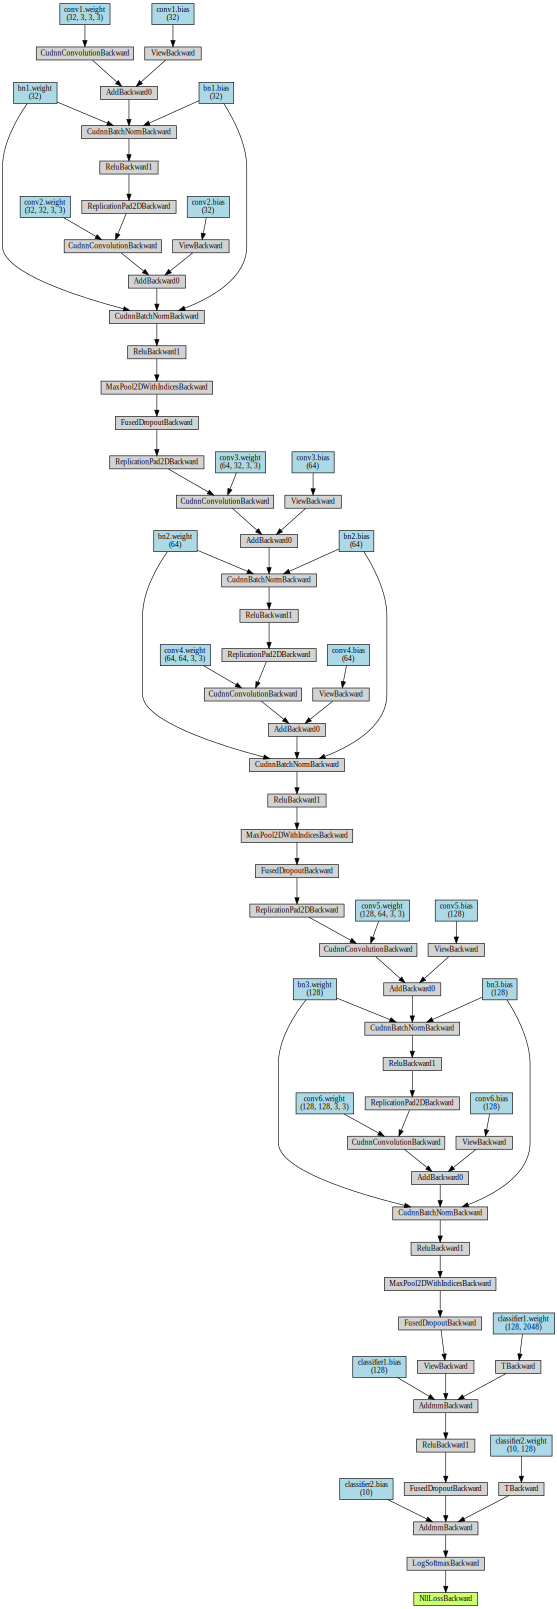

In [17]:
# 損失関数のグラフ表示
net = CNN_v5(n_output).to(device)
criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
make_dot(loss, params=dict(net.named_parameters()))

## コラム Batch Normlizationの処理内容

In [26]:
# 入力用ダミーデータの作成

torch.manual_seed(123)
inputs = torch.randn(1, 1, 10)
print(inputs)

tensor([[[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969,  0.2093, -0.9724,
          -0.7550,  0.3239, -0.1085]]])


In [27]:
# 入力ミニバッチデータの統計量計算

i_mean = inputs.mean()
i_var = inputs.var(unbiased=True)
i_std = inputs.std(unbiased=False)
print(i_mean, i_std, i_var)

tensor(-0.3101) tensor(0.4867) tensor(0.2632)


In [38]:
# BN関数の定義

bn = nn.BatchNorm1d(1)
print(bn.running_mean)
print(bn.running_var)
print(bn.weight.data)
print(bn.bias.data)

tensor([0.])
tensor([1.])
tensor([1.])
tensor([0.])


In [29]:
# BN関数の疑似呼び出し

bn.train()
print('===訓練モード1===')
outputs1 = bn(inputs)
print(outputs1.data)
print(bn.running_mean)
print(bn.running_var)

bn.eval()
print('===予測モード1===')
outputs2 = bn(inputs)
print(outputs2.data)
print(bn.running_mean)
print(bn.running_var)

bn.train()
print('===訓練モード2===')
outputs3 = bn(inputs)
print(outputs3.data)
print(bn.running_mean)
print(bn.running_var)

bn.eval()
print('===予測モード2===')
outputs4 = bn(inputs)
print(outputs4.data)
print(bn.running_mean)
print(bn.running_var)


===訓練モード1===
tensor([[[ 0.4081,  0.8844, -0.1224,  0.1431, -1.8222,  1.0671, -1.3608,
          -0.9143,  1.3027,  0.4142]]])
tensor([-0.0310])
tensor([0.9263])
===予測モード1===
tensor([[[-0.0836,  0.1573, -0.3518, -0.2176, -1.2114,  0.2496, -0.9781,
          -0.7523,  0.3688, -0.0805]]])
tensor([-0.0310])
tensor([0.9263])
===訓練モード2===
tensor([[[ 0.4081,  0.8844, -0.1224,  0.1431, -1.8222,  1.0671, -1.3608,
          -0.9143,  1.3027,  0.4142]]])
tensor([-0.0589])
tensor([0.8600])
===予測モード2===
tensor([[[-0.0567,  0.1933, -0.3351, -0.1957, -1.2271,  0.2892, -0.9850,
          -0.7507,  0.4128, -0.0535]]])
tensor([-0.0589])
tensor([0.8600])


In [30]:
# 訓練モードの出力

xt = (inputs - i_mean)/i_std * bn.weight + bn.bias
print(xt.data)

print(outputs1.data)

tensor([[[ 0.4081,  0.8845, -0.1224,  0.1431, -1.8223,  1.0671, -1.3608,
          -0.9143,  1.3027,  0.4142]]])
tensor([[[ 0.4081,  0.8844, -0.1224,  0.1431, -1.8222,  1.0671, -1.3608,
          -0.9143,  1.3027,  0.4142]]])


In [31]:
# 予測モードの出力

# 予測モードの出力

xp = (inputs-bn.running_mean)/torch.sqrt(bn.running_var)
print(xp.data)

print(outputs4.data)

tensor([[[-0.0567,  0.1933, -0.3351, -0.1957, -1.2271,  0.2892, -0.9850,
          -0.7507,  0.4128, -0.0535]]])
tensor([[[-0.0567,  0.1933, -0.3351, -0.1957, -1.2271,  0.2892, -0.9850,
          -0.7507,  0.4128, -0.0535]]])


In [36]:
# running_meanとrunnung_varの計算式

# 初期値
mean0 = 0
var0 = 1
momentum = bn.momentum

# 移動平均計算1回目
mean1 = (1-momentum) * mean0 +  momentum * i_mean
var1 = (1-momentum) * var0 +  momentum * i_var
print(mean1, var1)

# 移動平均計算2回目
mean2 = (1-momentum) * mean1 +  momentum * i_mean
var2 = (1-momentum) * var1 +  momentum * i_var
print(mean2, var2)


tensor(-0.0310) tensor(0.9263)
tensor(-0.0589) tensor(0.8600)
